<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/Depression_ML_DL_Adversaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1-Install dependencies

In [1]:
pip install --upgrade numpy pandas scikit-learn xgboost lightgbm torch torchvision torchaudio captum matplotlib seaborn imbalanced-learn opencv-python thinc

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached thinc-9.1.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached blis-1.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached thinc-9.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)


#2-Imports & device

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from xgboost import XGBClassifier
import lightgbm as lgb

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


#3-Load dataset & drop sum_phq

In [3]:

DATA_PATH = "/content/drive/MyDrive/DataSets/dataset-2_9.csv"

df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)

if "sum_phq" in df.columns:
    df = df.drop(columns=["sum_phq"])
    print("Dropped 'sum_phq' column.")

print("Shape after:", df.shape)
df.head()


Original shape: (672, 55)
Shape after: (672, 55)


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,PSQI10,PSQI11,PSQI12,PSQI13,PSQI14,PSQI15,PSQI16,PSQI17,PSQI18,PSQI19
0,15-30,Male,Overweight,Married,Higher secondary,Unemployed,High,Urban,Without family,Non-smoker,...,0,3,1,0,0,0,0,0,2,2
1,Above 30,Male,Normal,Married,Illiterate,Unemployed,Low,Rural,With family,Smoker,...,0,1,1,2,3,3,0,0,0,1
2,Above 30,Female,Normal,Unmarried,Primary,Unemployed,Middle,Rural,With family,Non-smoker,...,2,0,3,1,0,1,0,0,0,2
3,Above 30,Female,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,1,0,1,1,2,0,0,0,1
4,Above 30,Male,Normal,Married,Graduate/above,Student,Middle,Rural,With family,Non-smoker,...,1,0,2,1,1,2,0,1,0,2


#4-Encode categorical variables (label encode)

In [4]:
# Label-encode object columns (simple and reproducible)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns detected:", cat_cols)

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

print("Encoding complete.")
df.head()


Categorical columns detected: ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']
Encoding complete.


,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,PSQI10,PSQI11,PSQI12,PSQI13,PSQI14,PSQI15,PSQI16,PSQI17,PSQI18,PSQI19
0,0,1,1,0,1,3,0,1,1,0,...,0,3,1,0,0,0,0,0,2,2
1,1,1,0,0,2,3,1,0,0,1,...,0,1,1,2,3,3,0,0,0,1
2,1,0,0,1,3,3,2,0,0,0,...,2,0,3,1,0,1,0,0,0,2
3,1,0,0,0,0,2,2,0,0,0,...,1,1,0,1,1,2,0,0,0,1
4,1,1,0,0,0,2,2,0,0,0,...,1,0,2,1,1,2,0,1,0,2


#5-EDA: class distribution, heatmap, t-SNE

#**Class Distribution Countplot**

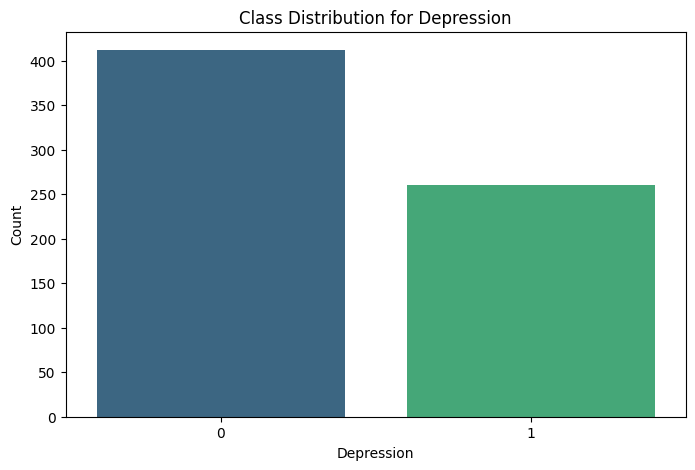

In [6]:
target = "Depression"

plt.figure(figsize=(8,5))
sns.countplot(x=target, data=df, palette='viridis')
plt.title(f'Class Distribution for {target}')
plt.xlabel(target)
plt.ylabel('Count')
plt.show()


#**Class Proportions**

In [7]:
print("Class proportions:")
print(df[target].value_counts(normalize=True).rename('proportion'))


Class proportions:
Depression
0    0.613095
1    0.386905
Name: proportion, dtype: float64


#**Correlation Heatmap (Numeric Features Only)**

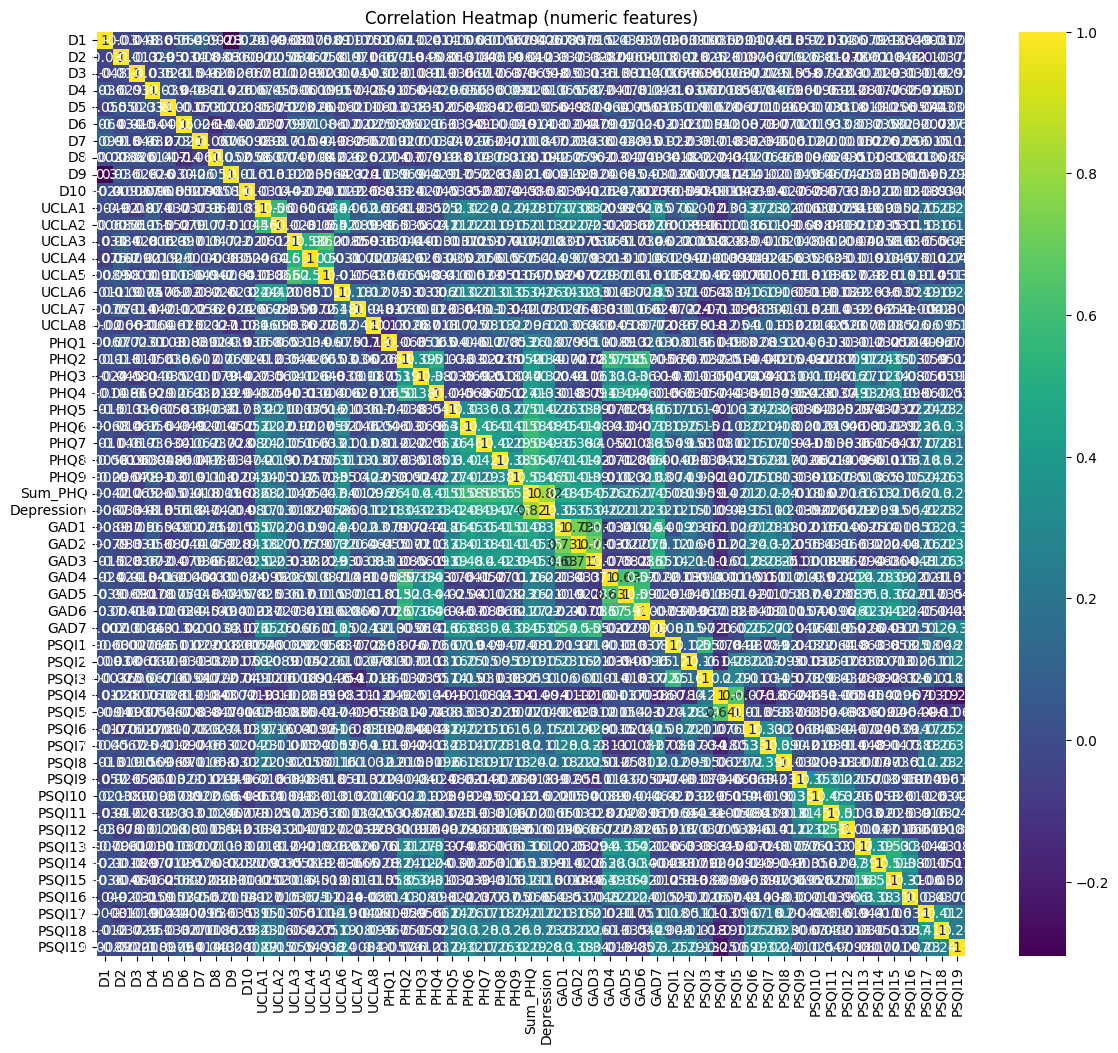

In [9]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True)
plt.title('Correlation Heatmap (numeric features)')
plt.show()

#**Prepare Data for t-SNE Visualization**

In [10]:
X_vis = df.drop(columns=[target])
y_vis = df[target]
X_vis_scaled = StandardScaler().fit_transform(X_vis)

n_samples_vis = min(2000, X_vis_scaled.shape[0])  # limit for speed
rng = np.random.default_rng(42)
sel_idx = rng.choice(X_vis_scaled.shape[0], size=n_samples_vis, replace=False)

X_vis_sub = X_vis_scaled[sel_idx]
y_vis_sub = y_vis.iloc[sel_idx].values


#**t-SNE Visualization**

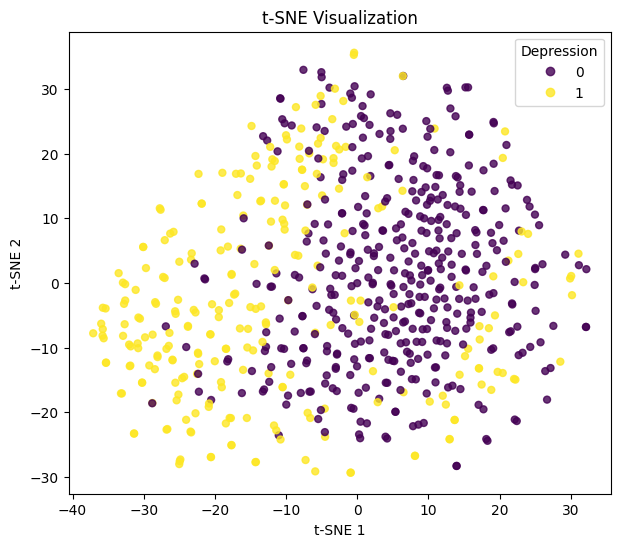

In [11]:
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
X2 = tsne.fit_transform(X_vis_sub)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=y_vis_sub, s=25, alpha=0.8, cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Create legend labels dynamically
handles, _ = scatter.legend_elements()
unique_labels = np.unique(y_vis_sub)
label_names = [str(l) for l in unique_labels]
plt.legend(handles, label_names, title=target)
plt.show()


#6-Split features & target and show distribution

In [12]:
X = df.drop(columns=[target])
y = df[target]

print("Feature shape:", X.shape)
print("Target counts:")
print(y.value_counts())


Feature shape: (672, 54)
Target counts:
Depression
0    412
1    260
Name: count, dtype: int64


#7-Train/Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train target distribution:")
print(y_train.value_counts())


Train shape: (537, 54)  Test shape: (135, 54)
Train target distribution:
Depression
0    329
1    208
Name: count, dtype: int64


#8-Apply SMOTE to training set

In [15]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE — train shape:", X_train_res.shape)
print("Resampled target distribution:")
print(pd.Series(y_train_res).value_counts())

After SMOTE — train shape: (658, 54)
Resampled target distribution:
Depression
0    329
1    329
Name: count, dtype: int64


#9-Standardize features (fit on resampled train)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)   # NOTE: fit on SMOTE-resampled train
X_test_scaled = scaler.transform(X_test)             # transform test (no SMOTE on test)

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaled shapes: (658, 54) (135, 54)


#10-Helpers: evaluate metrics & predict_proba wrapper

In [17]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

def print_metrics(y_true, y_pred, probs=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 (macro):", f1_score(y_true, y_pred, average='macro'))
    if probs is not None:
        try:
            # attempt AUC for binary
            if probs.ndim == 1 or (probs.ndim==2 and probs.shape[1]==1):
                auc = roc_auc_score(y_true, probs.ravel())
            else:
                auc = roc_auc_score(y_true, probs[:,1])
            print("AUC:", auc)
        except Exception:
            pass
    print(classification_report(y_true, y_pred, digits=4))

# sklearn predict_proba safe
from scipy.special import expit
def predict_proba_safe_sklearn(model, X_np):
    try:
        return model.predict_proba(X_np)
    except Exception:
        if hasattr(model, "decision_function"):
            dec = model.decision_function(X_np)
            if dec.ndim == 1:
                return expit(dec)
            else:
                expd = np.exp(dec - dec.max(axis=1, keepdims=True))
                return expd / expd.sum(axis=1, keepdims=True)
        else:
            preds = model.predict(X_np)
            classes = np.unique(preds)
            proba = np.zeros((len(preds), len(classes)))
            for i, c in enumerate(classes):
                proba[:, i] = (preds == c).astype(float)
            return proba


#11-Train classical & ensemble models (on SMOTE-scaled train)

In [18]:
# Classical & ensemble models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=5000, random_state=42)
lr.fit(X_train_scaled, y_train_res)
models["LogisticRegression"] = lr

# SVM (with probability)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_res)
models["SVM"] = svm

# Decision Tree (trained on scaled data for consistency)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train_res)
models["DecisionTree"] = dt

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_res)
models["RandomForest"] = rf

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train_res)
models["XGBoost"] = xgb

# LightGBM
lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train_scaled, y_train_res)
models["LightGBM"] = lgbm

print("Trained models:", list(models.keys()))


[LightGBM] [Info] Number of positive: 329, number of negative: 329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 658, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

#12-Evaluate clean performance (all models)

In [19]:
clean_results = []
for name, mdl in models.items():
    proba = predict_proba_safe_sklearn(mdl, X_test_scaled)
    if isinstance(proba, np.ndarray) and proba.ndim==2 and proba.shape[1] > 1:
        y_pred = np.argmax(proba, axis=1)
    elif isinstance(proba, np.ndarray) and proba.ndim==1:
        y_pred = (proba >= 0.5).astype(int)
    else:
        y_pred = mdl.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    try:
        aucv = roc_auc_score(y_test, proba[:,1]) if isinstance(proba, np.ndarray) and proba.ndim==2 else (roc_auc_score(y_test, proba) if isinstance(proba, np.ndarray) else np.nan)
    except Exception:
        aucv = np.nan
    clean_results.append({"model": name, "accuracy": acc, "f1_macro": f1m, "auc": aucv})

clean_df = pd.DataFrame(clean_results).sort_values("accuracy", ascending=False)
display(clean_df)


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
4,XGBoost,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.955556,0.953082,0.993281
1,SVM,0.940741,0.935928,0.978452


#13-Prepare PyTorch dataset and MLP surrogate

In [20]:
# Create PyTorch datasets (use scaled arrays)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res.values if hasattr(y_train_res, "values") else y_train_res, dtype=torch.long)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values if hasattr(y_test, "values") else y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# Define MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1), nn.ReLU(),
            nn.Linear(hidden1, hidden2), nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x): return self.net(x)

input_dim = X_train_scaled.shape[1]
num_classes = int(np.unique(y_train_res).shape[0])
surrogate = MLP(input_dim, num_classes=num_classes).to(device)

# Train the surrogate briefly (used for crafting attacks)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(surrogate.parameters(), lr=1e-3)

surrogate.train()
for epoch in range(20):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = surrogate(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    if (epoch+1) % 5 == 0:
        print(f"Surrogate train epoch {epoch+1}, loss {epoch_loss/len(train_ds):.4f}")

surrogate.eval()
print("Surrogate ready on device:", device)


Surrogate train epoch 5, loss 0.0705
Surrogate train epoch 10, loss 0.0069
Surrogate train epoch 15, loss 0.0021
Surrogate train epoch 20, loss 0.0010
Surrogate ready on device: cuda


#14-Attack functions (FGSM & PGD) — using surrogate

In [21]:
# prepare clipping bounds (in scaled space)
x_min = torch.tensor(X_train_scaled.min(axis=0), dtype=torch.float32, device=device)
x_max = torch.tensor(X_train_scaled.max(axis=0), dtype=torch.float32, device=device)

def fgsm_torch(model, x, y, eps):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    y = y.to(device)
    logits = model(x_adv)
    loss = nn.CrossEntropyLoss()(logits, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + eps * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, x_min, x_max)
    return x_adv.detach()

def pgd_torch(model, x, y, eps, alpha=0.01, steps=20):
    x_orig = x.clone().detach().to(device)
    x_adv = x.clone().detach().to(device).requires_grad_(True)
    y = y.to(device)
    for _ in range(steps):
        logits = model(x_adv)
        loss = nn.CrossEntropyLoss()(logits, y)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            x_adv = x_adv + alpha * x_adv.grad.sign()
            x_adv = torch.min(torch.max(x_adv, x_orig - eps), x_orig + eps)
            x_adv = torch.clamp(x_adv, x_min, x_max)
        x_adv.requires_grad_(True)
    return x_adv.detach()


#15-Generate adversarial test sets (transfer attacks)

In [22]:
# Build adv_sets (numpy arrays) based on surrogate on full test set
X_test_for_attack = X_test_scaled.copy()
X_te_t = torch.tensor(X_test_for_attack, dtype=torch.float32, device=device)
y_te_t = torch.tensor(y_test.values if hasattr(y_test, "values") else y_test, dtype=torch.long, device=device)

epsilons = [0.0, 0.01, 0.02, 0.05, 0.1]
adv_sets = {"clean": X_test_for_attack.copy()}

for eps in epsilons:
    if eps == 0.0:
        continue
    # FGSM
    X_adv_fgsm = fgsm_torch(surrogate, X_te_t, y_te_t, torch.tensor(float(eps)).to(device))
    adv_sets[f"fgsm_eps_{eps}"] = X_adv_fgsm.cpu().numpy()
    # PGD
    X_adv_pgd = pgd_torch(surrogate, X_te_t, y_te_t, float(eps), alpha=max(1e-3, float(eps)/5.0), steps=30)
    adv_sets[f"pgd_eps_{eps}"] = X_adv_pgd.cpu().numpy()

print("Generated adversarial sets:", list(adv_sets.keys()))


Generated adversarial sets: ['clean', 'fgsm_eps_0.01', 'pgd_eps_0.01', 'fgsm_eps_0.02', 'pgd_eps_0.02', 'fgsm_eps_0.05', 'pgd_eps_0.05', 'fgsm_eps_0.1', 'pgd_eps_0.1']


#16-Evaluate all sklearn models on adv sets (transfer)

In [23]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
results_transfer = {}

def eval_models_on_dataset(models_dict, X_np, y_true):
    rows = []
    for name, mdl in models_dict.items():
        try:
            proba = predict_proba_safe_sklearn(mdl, X_np)
            if isinstance(proba, np.ndarray) and proba.ndim==2 and proba.shape[1] > 1:
                y_pred = np.argmax(proba, axis=1)
            elif isinstance(proba, np.ndarray) and proba.ndim==1:
                y_pred = (proba >= 0.5).astype(int)
            else:
                y_pred = mdl.predict(X_np)
            acc = accuracy_score(y_true, y_pred)
            f1m = f1_score(y_true, y_pred, average='macro')
            aucv = np.nan
            try:
                if isinstance(proba, np.ndarray) and proba.ndim==2 and proba.shape[1] >= 2:
                    aucv = roc_auc_score(y_true, proba[:,1])
                elif isinstance(proba, np.ndarray) and proba.ndim==1:
                    aucv = roc_auc_score(y_true, proba)
            except Exception:
                aucv = np.nan
            rows.append({"model": name, "accuracy": acc, "f1_macro": f1m, "auc": aucv})
        except Exception as e:
            rows.append({"model": name, "accuracy": np.nan, "f1_macro": np.nan, "auc": np.nan, "error": str(e)})
    return pd.DataFrame(rows)

for tag, X_adv in adv_sets.items():
    df_res = eval_models_on_dataset(models, X_adv, y_test.values)
    results_transfer[tag] = df_res
    print(f"--- Results for: {tag} ---")
    display(df_res.sort_values("accuracy", ascending=False))


--- Results for: clean ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
4,XGBoost,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.955556,0.953082,0.993281
1,SVM,0.940741,0.935928,0.978452


--- Results for: fgsm_eps_0.01 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.955556,0.953082,0.991427
1,SVM,0.925926,0.919910,0.976135
4,XGBoost,0.896296,0.883333,0.865385


--- Results for: pgd_eps_0.01 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.955556,0.953082,0.991427
1,SVM,0.925926,0.919910,0.976135
4,XGBoost,0.896296,0.883333,0.865385


--- Results for: fgsm_eps_0.02 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.948148,0.945455,0.990037
1,SVM,0.911111,0.903017,0.972428
4,XGBoost,0.896296,0.883333,0.865385


--- Results for: pgd_eps_0.02 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.948148,0.945455,0.989805
1,SVM,0.911111,0.903017,0.971965
4,XGBoost,0.896296,0.883333,0.865385


--- Results for: fgsm_eps_0.05 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.918519,0.914286,0.981001
4,XGBoost,0.896296,0.883333,0.865385
1,SVM,0.881481,0.870690,0.956673


--- Results for: pgd_eps_0.05 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
0,LogisticRegression,0.918519,0.914286,0.981233
4,XGBoost,0.896296,0.883333,0.865385
1,SVM,0.881481,0.870690,0.956441


--- Results for: fgsm_eps_0.1 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
4,XGBoost,0.896296,0.883333,0.865385
0,LogisticRegression,0.866667,0.860216,0.952966
1,SVM,0.837037,0.822198,0.922150


--- Results for: pgd_eps_0.1 ---


,model,accuracy,f1_macro,auc
3,RandomForest,1.000000,1.000000,1.000000
2,DecisionTree,1.000000,1.000000,1.000000
5,LightGBM,1.000000,1.000000,1.000000
4,XGBoost,0.896296,0.883333,0.865385
0,LogisticRegression,0.859259,0.851948,0.952966
1,SVM,0.829630,0.814969,0.921918


#17-Black-box noise attacks (uniform L-inf & gaussian)

In [24]:
# Noise generators (in scaled feature space)
def uniform_linf_noise_attack(X_np, eps):
    noise = np.random.uniform(low=-eps, high=eps, size=X_np.shape)
    return X_np + noise

def gaussian_noise_attack(X_np, eps):
    feat_std = np.std(X_train_scaled, axis=0)
    sigma = eps * (feat_std + 1e-10)
    noise = np.random.normal(loc=0.0, scale=sigma, size=X_np.shape)
    return X_np + noise

# Sweep and evaluate
epsilons_bb = [0.0, 0.01, 0.02, 0.05, 0.1]
bb_results = []
for eps in epsilons_bb:
    # uniform
    X_uni = uniform_linf_noise_attack(X_test_for_attack, eps)
    res_uni = eval_models_on_dataset(models, X_uni, y_test.values)
    res_uni['attack'] = f'uniform_eps_{eps}'
    res_uni['eps'] = eps
    bb_results.append(res_uni)
    # gaussian
    X_gau = gaussian_noise_attack(X_test_for_attack, eps)
    res_gau = eval_models_on_dataset(models, X_gau, y_test.values)
    res_gau['attack'] = f'gaussian_eps_{eps}'
    res_gau['eps'] = eps
    bb_results.append(res_gau)

bb_all = pd.concat(bb_results, ignore_index=True)
print("Black-box noise attacks (sample):")
display(bb_all.head())


Black-box noise attacks (sample):


,model,accuracy,f1_macro,auc,attack,eps
0,LogisticRegression,0.955556,0.953082,0.993281,uniform_eps_0.0,0.0
1,SVM,0.940741,0.935928,0.978452,uniform_eps_0.0,0.0
2,DecisionTree,1.000000,1.000000,1.000000,uniform_eps_0.0,0.0
3,RandomForest,1.000000,1.000000,1.000000,uniform_eps_0.0,0.0
4,XGBoost,1.000000,1.000000,1.000000,uniform_eps_0.0,0.0


#18-Plot robustness curves (transfer + black-box)

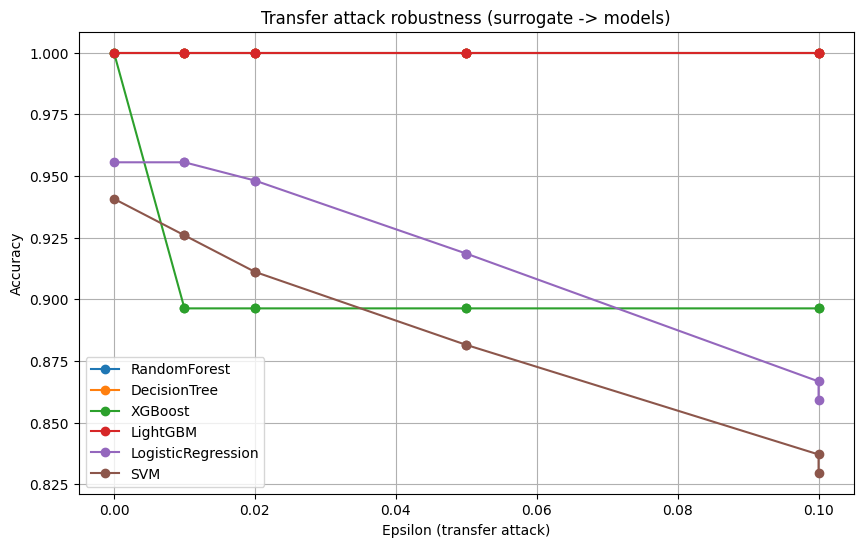

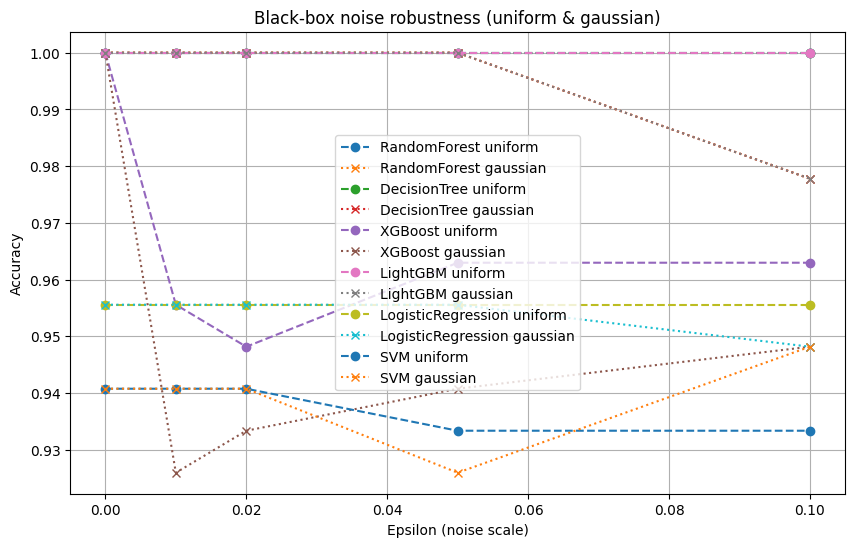

In [25]:
# Select top models by clean accuracy
clean_df = results_transfer['clean'].copy().sort_values("accuracy", ascending=False)
top_models = clean_df['model'].tolist()[:6]

# Transfer attacks: gather accuracies per model per eps
plot_rows = []
for tag, df_res in results_transfer.items():
    eps_val = 0.0 if tag == 'clean' else float(tag.split('_')[-1])
    for _, r in df_res.iterrows():
        if r['model'] in top_models:
            plot_rows.append({"model": r['model'], "attack": tag, "eps": eps_val, "accuracy": r['accuracy']})
plot_df = pd.DataFrame(plot_rows)

plt.figure(figsize=(10,6))
for m in top_models:
    sub = plot_df[plot_df['model']==m].sort_values('eps')
    if sub.empty: continue
    plt.plot(sub['eps'], sub['accuracy'], marker='o', label=m)
plt.xlabel("Epsilon (transfer attack)")
plt.ylabel("Accuracy")
plt.title("Transfer attack robustness (surrogate -> models)")
plt.legend()
plt.grid(True)
plt.show()

# Black-box noise plots
plt.figure(figsize=(10,6))
for m in top_models:
    sub_uni = bb_all[(bb_all['model']==m) & (bb_all['attack'].str.startswith('uniform'))].sort_values('eps')
    sub_gau = bb_all[(bb_all['model']==m) & (bb_all['attack'].str.startswith('gaussian'))].sort_values('eps')
    if not sub_uni.empty:
        plt.plot(sub_uni['eps'], sub_uni['accuracy'], marker='o', linestyle='--', label=f"{m} uniform")
    if not sub_gau.empty:
        plt.plot(sub_gau['eps'], sub_gau['accuracy'], marker='x', linestyle=':', label=f"{m} gaussian")
plt.xlabel("Epsilon (noise scale)")
plt.ylabel("Accuracy")
plt.title("Black-box noise robustness (uniform & gaussian)")
plt.legend()
plt.grid(True)
plt.show()


#19-Short robustness summary (drops in accuracy)

In [26]:
# summarize drops: clean -> strongest PGD & clean -> largest uniform
pgd_keys = [k for k in results_transfer.keys() if k.startswith('pgd_eps_')]
pgd_eps_vals = sorted([float(k.split('pgd_eps_')[1]) for k in pgd_keys]) if pgd_keys else []
pgd_max_key = f"pgd_eps_{pgd_eps_vals[-1]}" if pgd_eps_vals else None

summary_rows = []
for m in models.keys():
    clean_acc = results_transfer['clean'].loc[results_transfer['clean']['model']==m, 'accuracy'].values
    clean_acc = float(clean_acc[0]) if len(clean_acc)>0 else np.nan
    transfer_worst_acc = np.nan
    if pgd_max_key and pgd_max_key in results_transfer:
        transfer_worst_acc = float(results_transfer[pgd_max_key].loc[results_transfer[pgd_max_key]['model']==m, 'accuracy'].values[0])
    uni_acc = bb_all.loc[(bb_all['model']==m) & (bb_all['attack']==f'uniform_eps_{epsilons_bb[-1]}'), 'accuracy']
    uni_acc = float(uni_acc.values[0]) if len(uni_acc)>0 else np.nan

    summary_rows.append({
        "model": m,
        "clean_acc": clean_acc,
        "transfer_pgd_worst_acc": transfer_worst_acc,
        f"uniform_eps_{epsilons_bb[-1]}_acc": uni_acc,
        "drop_transfer_pgd": clean_acc - transfer_worst_acc if (not np.isnan(clean_acc) and not np.isnan(transfer_worst_acc)) else np.nan,
        "drop_uniform": clean_acc - uni_acc if (not np.isnan(clean_acc) and not np.isnan(uni_acc)) else np.nan
    })

summary_df = pd.DataFrame(summary_rows).sort_values("drop_transfer_pgd", ascending=False)
print("Summary of robustness drops (higher drop -> more vulnerable):")
display(summary_df)


Summary of robustness drops (higher drop -> more vulnerable):


,model,clean_acc,transfer_pgd_worst_acc,uniform_eps_0.1_acc,drop_transfer_pgd,drop_uniform
1,SVM,0.940741,0.829630,0.933333,0.111111,0.007407
4,XGBoost,1.000000,0.896296,0.962963,0.103704,0.037037
0,LogisticRegression,0.955556,0.859259,0.955556,0.096296,0.000000
2,DecisionTree,1.000000,1.000000,1.000000,0.000000,0.000000
3,RandomForest,1.000000,1.000000,1.000000,0.000000,0.000000
5,LightGBM,1.000000,1.000000,1.000000,0.000000,0.000000


#20-Adversarial training for MLP surrogate

In [28]:
# Optional: quick adversarial training for surrogate (FGSM) and evaluate
ADV_EPS = 0.05
adv_mlp = MLP(input_dim, num_classes=num_classes).to(device)
opt_adv = optim.Adam(adv_mlp.parameters(), lr=1e-3)
adv_mlp.train()
for epoch in range(6):
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        # create fgsm adversarial examples on the fly
        xb_adv = fgsm_torch(adv_mlp, xb, yb, torch.tensor(ADV_EPS).to(device))
        opt_adv.zero_grad()
        logits = adv_mlp(xb_adv)
        loss = nn.CrossEntropyLoss()(logits, yb)
        loss.backward()
        opt_adv.step()
        epoch_loss += loss.item() * xb.size(0)
    print(f"[AdvTrain] epoch {epoch+1}, loss {epoch_loss/len(train_ds):.4f}")

# Evaluate adv-trained surrogate on clean & adv
adv_mlp.eval()
with torch.no_grad():
    logits_clean = adv_mlp(X_test_t.to(device)).cpu().numpy()
    preds_clean = np.argmax(logits_clean, axis=1)
    print("Adv-MLP clean acc:", accuracy_score(y_test, preds_clean))

# Generate adversarial examples outside no_grad
X_adv = fgsm_torch(adv_mlp, X_test_t.to(device), y_test_t.to(device), torch.tensor(ADV_EPS).to(device))

with torch.no_grad():
    logits_adv = adv_mlp(X_adv).cpu().numpy()
    preds_adv = np.argmax(logits_adv, axis=1)
    print(f"Adv-MLP FGSM eps={ADV_EPS} acc:", accuracy_score(y_test, preds_adv))

[AdvTrain] epoch 1, loss 0.6074
[AdvTrain] epoch 2, loss 0.3978
[AdvTrain] epoch 3, loss 0.2577
[AdvTrain] epoch 4, loss 0.1936
[AdvTrain] epoch 5, loss 0.1344
[AdvTrain] epoch 6, loss 0.0974
Adv-MLP clean acc: 0.9555555555555556
Adv-MLP FGSM eps=0.05 acc: 0.9259259259259259
